In [1]:
!python -V

Python 3.9.21


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1748145641153, experiment_id='1', last_update_time=1748145641153, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [7]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    #numerical = ['trip_distance']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO']
numerical = ['trip_distance']

In [11]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
import sklearn
print(sklearn.__version__)

1.6.1


In [13]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [14]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [25]:
with mlflow.start_run():

    mlflow.set_tag("developer","Andre")

    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")

    alpha=0.01
    mlflow.log_param("alpha",alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    mlflow.log_metric("rmse",rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin",artifact_path="models_pickle")

In [26]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [27]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [29]:
with mlflow.start_run():
    best_params = {
        'learning_rate': 0.4103718260632211,
        'max_depth': 25,
        'min_child_weight': 2.8418841411295532,
        'objective': 'reg:linear',
        'reg_alpha': 0.07824377774267278,
        'reg_lambda': 0.3335341043411823,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:34:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.13818
[1]	validation-rmse:7.70557
[2]	validation-rmse:7.08911
[3]	validation-rmse:6.81601
[4]	validation-rmse:6.68986
[5]	validation-rmse:6.62495
[6]	validation-rmse:6.59039
[7]	validation-rmse:6.57012
[8]	validation-rmse:6.55858
[9]	validation-rmse:6.54734
[10]	validation-rmse:6.54338
[11]	validation-rmse:6.53987
[12]	validation-rmse:6.53432
[13]	validation-rmse:6.52996
[14]	validation-rmse:6.52692
[15]	validation-rmse:6.52497
[16]	validation-rmse:6.51760
[17]	validation-rmse:6.51349
[18]	validation-rmse:6.50929
[19]	validation-rmse:6.50680
[20]	validation-rmse:6.50394
[21]	validation-rmse:6.50040
[22]	validation-rmse:6.49662
[23]	validation-rmse:6.49165
[24]	validation-rmse:6.48913
[25]	validation-rmse:6.48622
[26]	validation-rmse:6.48267
[27]	validation-rmse:6.48056
[28]	validation-rmse:6.47749
[29]	validation-rmse:6.47532
[30]	validation-rmse:6.47331
[31]	validation-rmse:6.47086
[32]	validation-rmse:6.46870
[33]	validation-rmse:6.46454
[34]	validation-rmse:6.4

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:35:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/25 05:35:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [30]:
logged_model = 'runs:/1a5c6627e05d41e2bf06d2c7d931e9b8/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
#import pandas as pd
#loaded_model.predict(pd.DataFrame(data))

In [31]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 1a5c6627e05d41e2bf06d2c7d931e9b8

In [32]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [33]:
xgboost_model

In [34]:
y_pred = xgboost_model.predict(valid)
y_pred[:10]

array([14.172409 ,  6.472752 , 16.125614 , 24.86739  ,  9.378094 ,
       17.30181  , 10.366088 ,  7.4032803,  9.07937  , 17.641502 ],
      dtype=float32)

In [25]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42 
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:30:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.13818                           
[1]	validation-rmse:7.70557                           
[2]	validation-rmse:7.08911                           
[3]	validation-rmse:6.81601                           
[4]	validation-rmse:6.68986                           
[5]	validation-rmse:6.62495                           
[6]	validation-rmse:6.59039                           
[7]	validation-rmse:6.57012                           
[8]	validation-rmse:6.55858                           
[9]	validation-rmse:6.54734                           
[10]	validation-rmse:6.54338                          
[11]	validation-rmse:6.53987                          
[12]	validation-rmse:6.53432                          
[13]	validation-rmse:6.52996                          
[14]	validation-rmse:6.52692                          
[15]	validation-rmse:6.52497                          
[16]	validation-rmse:6.51760                          
[17]	validation-rmse:6.51349                          
[18]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:31:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62995                                                    
[1]	validation-rmse:11.10078                                                    
[2]	validation-rmse:10.62110                                                    
[3]	validation-rmse:10.18812                                                    
[4]	validation-rmse:9.79782                                                     
[5]	validation-rmse:9.44639                                                     
[6]	validation-rmse:9.13068                                                     
[7]	validation-rmse:8.84761                                                     
[8]	validation-rmse:8.59456                                                     
[9]	validation-rmse:8.36789                                                     
[10]	validation-rmse:8.16596                                                    
[11]	validation-rmse:7.98584                                                    
[12]	validation-rmse:7.82538

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:34:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.86732                                                        
[1]	validation-rmse:6.59162                                                        
[2]	validation-rmse:6.55312                                                        
[3]	validation-rmse:6.54905                                                        
[4]	validation-rmse:6.53580                                                        
[5]	validation-rmse:6.52939                                                        
[6]	validation-rmse:6.52189                                                        
[7]	validation-rmse:6.50741                                                        
[8]	validation-rmse:6.50325                                                        
[9]	validation-rmse:6.49959                                                        
[10]	validation-rmse:6.49674                                                       
[11]	validation-rmse:6.48920                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:35:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.36031                                                       
[1]	validation-rmse:7.95640                                                       
[2]	validation-rmse:7.31093                                                       
[3]	validation-rmse:7.01444                                                       
[4]	validation-rmse:6.87838                                                       
[5]	validation-rmse:6.80874                                                       
[6]	validation-rmse:6.76705                                                       
[7]	validation-rmse:6.74081                                                       
[8]	validation-rmse:6.72030                                                       
[9]	validation-rmse:6.70846                                                       
[10]	validation-rmse:6.70088                                                      
[11]	validation-rmse:6.69637                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:37:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.59614                                                       
[1]	validation-rmse:9.42769                                                        
[2]	validation-rmse:8.57545                                                        
[3]	validation-rmse:7.97194                                                        
[4]	validation-rmse:7.55609                                                        
[5]	validation-rmse:7.26229                                                        
[6]	validation-rmse:7.06099                                                        
[7]	validation-rmse:6.92400                                                        
[8]	validation-rmse:6.82428                                                        
[9]	validation-rmse:6.74934                                                        
[10]	validation-rmse:6.70223                                                       
[11]	validation-rmse:6.66236                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:39:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.96785                                                       
[2]	validation-rmse:10.44610                                                       
[3]	validation-rmse:9.98404                                                        
[4]	validation-rmse:9.57525                                                        
[5]	validation-rmse:9.21465                                                        
[6]	validation-rmse:8.89787                                                        
[7]	validation-rmse:8.61975                                                        
[8]	validation-rmse:8.37720                                                        
[9]	validation-rmse:8.16465                                                        
[10]	validation-rmse:7.97967                                                       
[11]	validation-rmse:7.81818                                                       
[12]	validation-rmse:7.67752                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:40:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.88522                                                        
[1]	validation-rmse:6.71128                                                        
[2]	validation-rmse:6.68120                                                        
[3]	validation-rmse:6.67599                                                        
[4]	validation-rmse:6.66555                                                        
[5]	validation-rmse:6.66133                                                        
[6]	validation-rmse:6.65743                                                        
[7]	validation-rmse:6.65589                                                        
[8]	validation-rmse:6.65509                                                        
[9]	validation-rmse:6.65358                                                        
[10]	validation-rmse:6.65191                                                       
[11]	validation-rmse:6.64963                                                

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:41:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.35829                                                       
[1]	validation-rmse:7.17545                                                       
[2]	validation-rmse:6.83254                                                       
[3]	validation-rmse:6.71104                                                       
[4]	validation-rmse:6.66614                                                       
[5]	validation-rmse:6.64617                                                       
[6]	validation-rmse:6.62937                                                       
[7]	validation-rmse:6.62216                                                       
[8]	validation-rmse:6.61745                                                       
[9]	validation-rmse:6.61462                                                       
[10]	validation-rmse:6.61005                                                      
[11]	validation-rmse:6.60845                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:42:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.48279                                                     
[1]	validation-rmse:8.04059                                                     
[2]	validation-rmse:7.32156                                                     
[3]	validation-rmse:6.96825                                                     
[4]	validation-rmse:6.78896                                                     
[5]	validation-rmse:6.69482                                                     
[6]	validation-rmse:6.64403                                                     
[7]	validation-rmse:6.61170                                                     
[8]	validation-rmse:6.58879                                                     
[9]	validation-rmse:6.57468                                                     
[10]	validation-rmse:6.56304                                                    
[11]	validation-rmse:6.54922                                                    
[12]	validation-rmse:6.54300

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:44:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.92506                                                     
[1]	validation-rmse:6.94450                                                     
[2]	validation-rmse:6.71570                                                     
[3]	validation-rmse:6.64369                                                     
[4]	validation-rmse:6.61110                                                     
[5]	validation-rmse:6.59038                                                     
[6]	validation-rmse:6.58010                                                     
[7]	validation-rmse:6.57413                                                     
[8]	validation-rmse:6.57018                                                     
[9]	validation-rmse:6.56443                                                     
[10]	validation-rmse:6.56195                                                    
[11]	validation-rmse:6.55833                                                    
[12]	validation-rmse:6.55582

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:45:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73047                                                     
[1]	validation-rmse:11.28557                                                     
[2]	validation-rmse:10.87612                                                     
[3]	validation-rmse:10.49993                                                     
[4]	validation-rmse:10.15445                                                     
[5]	validation-rmse:9.83770                                                      
[6]	validation-rmse:9.54770                                                      
[7]	validation-rmse:9.28258                                                      
[8]	validation-rmse:9.04050                                                      
[9]	validation-rmse:8.81997                                                      
[10]	validation-rmse:8.61921                                                     
[11]	validation-rmse:8.43669                                                     
[12]	validation-

In [ ]:
params = {
    'learning_rate': 0.4103718260632211,
    'max_depth': 25,
    'min_child_weight': 2.8418841411295532,
    'objective': 'reg:linear',
    'reg_alpha': 0.07824377774267278,
    'reg_lambda': 0.3335341043411823,
    'seed': 42
}

#mlflow.xgboost.autolog() crash kernel on github codespace

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [05:09:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.13818
[1]	validation-rmse:7.70557
[2]	validation-rmse:7.08911
[3]	validation-rmse:6.81601
[4]	validation-rmse:6.68986
[5]	validation-rmse:6.62495
[6]	validation-rmse:6.59039
[7]	validation-rmse:6.57012
[8]	validation-rmse:6.55858
[9]	validation-rmse:6.54734
[10]	validation-rmse:6.54338
[11]	validation-rmse:6.53987
[12]	validation-rmse:6.53432
[13]	validation-rmse:6.52996
[14]	validation-rmse:6.52692
[15]	validation-rmse:6.52497
[16]	validation-rmse:6.51760
[17]	validation-rmse:6.51349
[18]	validation-rmse:6.50929
[19]	validation-rmse:6.50680
[20]	validation-rmse:6.50394
[21]	validation-rmse:6.50040
[22]	validation-rmse:6.49662
[23]	validation-rmse:6.49165
[24]	validation-rmse:6.48913
[25]	validation-rmse:6.48622
[26]	validation-rmse:6.48267
[27]	validation-rmse:6.48056
[28]	validation-rmse:6.47749
[29]	validation-rmse:6.47532
[30]	validation-rmse:6.47331
[31]	validation-rmse:6.47086
[32]	validation-rmse:6.46870
[33]	validation-rmse:6.46454
[34]	validation-rmse:6.4

In [19]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.703735141467915

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


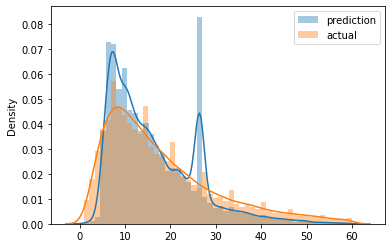

In [126]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

In [127]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)